In [1]:
import tensorflow as tf
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tensorflow import keras
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#copy from train.ipynb
class DataGenerator(tf.keras.utils.Sequence):
    """
    mode: "train" "val", "test"
    """
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        self.aug = aug
        self.indexes = np.arange(len(self.mask_paths))
        # Augmentation
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5),
            iaa.Affine(
                rotate=(90, -90), # random rotate -90 ~ +90 degree
                shear=(-3, 3), # random shear
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, index):
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :,::-1]
            img = self.preprocess(img)
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path)) # (H, W)
                mask = self.preprocess(mask)
                y[i] = np.expand_dims(mask, axis=-1) # (H, W) -> (H, W, 1)
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [4]:
BS = 4
IMG_SIZE = 512

In [5]:
all_paths = glob('/content/drive/MyDrive/Project/Vessel_segmentation/datasets/train/*.tif')
test_paths = sorted(glob('/content/drive/MyDrive/Project/Vessel_segmentation/datasets/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)
train_gen = DataGenerator(train_paths, BS, IMG_SIZE, shuffle=True, mode='train', aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

In [6]:
# UNet
# Functional API
def conv_bn(x, filters):
    x = keras.layers.Conv2D(filters=filters, kernel_size=3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    return x

# Subclass
class ConvBN(keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        # Method 1
        self.conv = keras.layers.Conv2D(filters=filters, kernel_size=3, padding='same')
        self.bn = keras.layers.BatchNormalization()
        self.act = keras.layers.ReLU()
        # Method 2
        self.seq = models.Sequential([
            keras.layers.Conv2D(filters=filters, kernel_size=3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU()
        ])
    def call(self, x):
        # Method 1
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
        # Method 2
        return self.seq(x)

# Encoder
input_layer = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_bn(input_layer, 8)
# x = ConvBN(8)(x)
c1 = conv_bn(x, 8)
x = keras.layers.MaxPool2D()(c1)
x = conv_bn(x, 16)
c2 = conv_bn(x, 16)
x = keras.layers.MaxPool2D()(c2)
x = conv_bn(x, 32)
c3 = conv_bn(x, 32)
x = keras.layers.MaxPool2D()(c3)
x = conv_bn(x, 64)
c4 = conv_bn(x, 64)


# Decoder
x = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2,2))(c4),
                        c3], axis=-1)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2,2))(x),
                        c2], axis=-1)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = keras.layers.concatenate([keras.layers.UpSampling2D(size=(2,2))(x),
                        c1], axis=-1)
x = conv_bn(x, 128)
x = conv_bn(x, 128)

output_layer = keras.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid')(x)

model =keras.models.Model(input_layer, output_layer)

In [7]:
model_final = keras.models.load_model('/content/drive/MyDrive/Project/Vessel_segmentation/seg.h5', compile=False)

0
1/1 [==============================] - 15s 15s/step


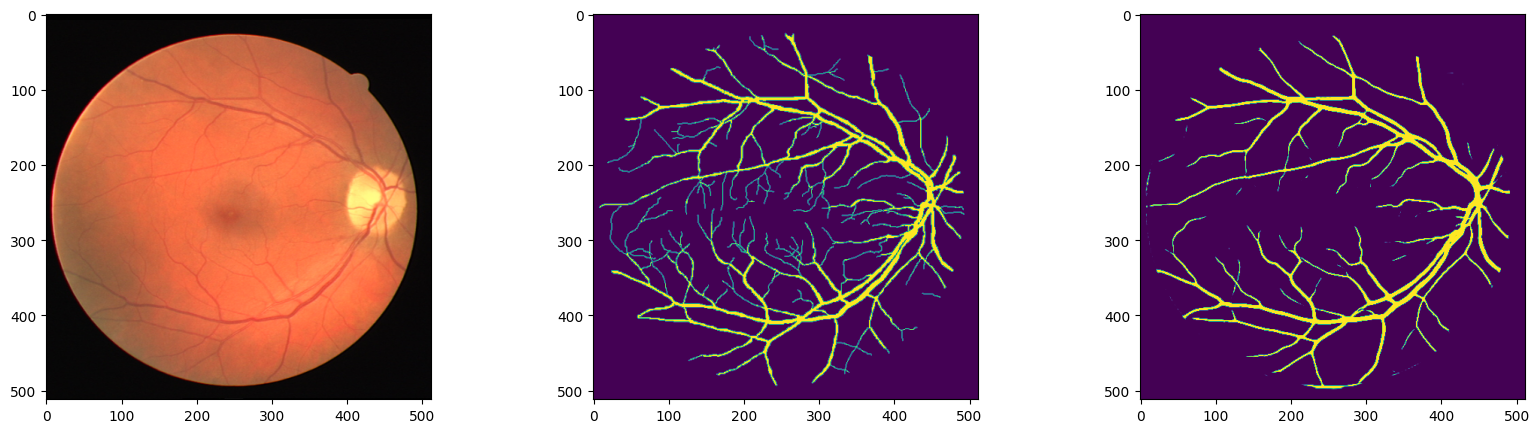

In [15]:
# Sample 1 batch
batch_idx = np.random.randint(len(val_gen))
print(batch_idx)
data = val_gen[batch_idx]
imgs, mask = data # (bs, 512, 512, 3), (bs, 512, 512, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(imgs[img_idx])

# show ground truth & model prediction
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0])
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [16]:
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[1.8469574e-06, 6.7570154e-06, 2.5950845e-05, ..., 1.7433726e-05,
        9.4639145e-06, 6.1764240e-07],
       [1.8493985e-05, 5.2110281e-06, 1.0737196e-05, ..., 2.7883996e-06,
        1.9222211e-06, 1.6726738e-06],
       [1.7853308e-05, 9.6154408e-06, 1.7716015e-05, ..., 3.0615545e-06,
        1.8982906e-06, 1.6181634e-06],
       ...,
       [1.2895500e-05, 8.8515881e-06, 9.7893253e-06, ..., 1.9829247e-06,
        3.6332751e-06, 1.5745705e-06],
       [6.0224693e-06, 4.5544543e-06, 7.4523509e-06, ..., 1.0909660e-06,
        1.4072627e-06, 1.2122380e-06],
       [3.1119803e-06, 8.0691971e-06, 8.8835714e-06, ..., 2.4360022e-06,
        2.6502835e-06, 1.1827256e-06]], dtype=float32)

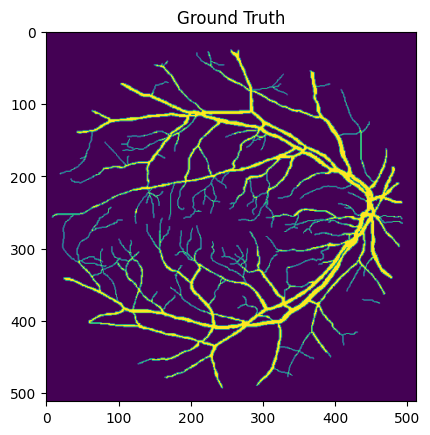

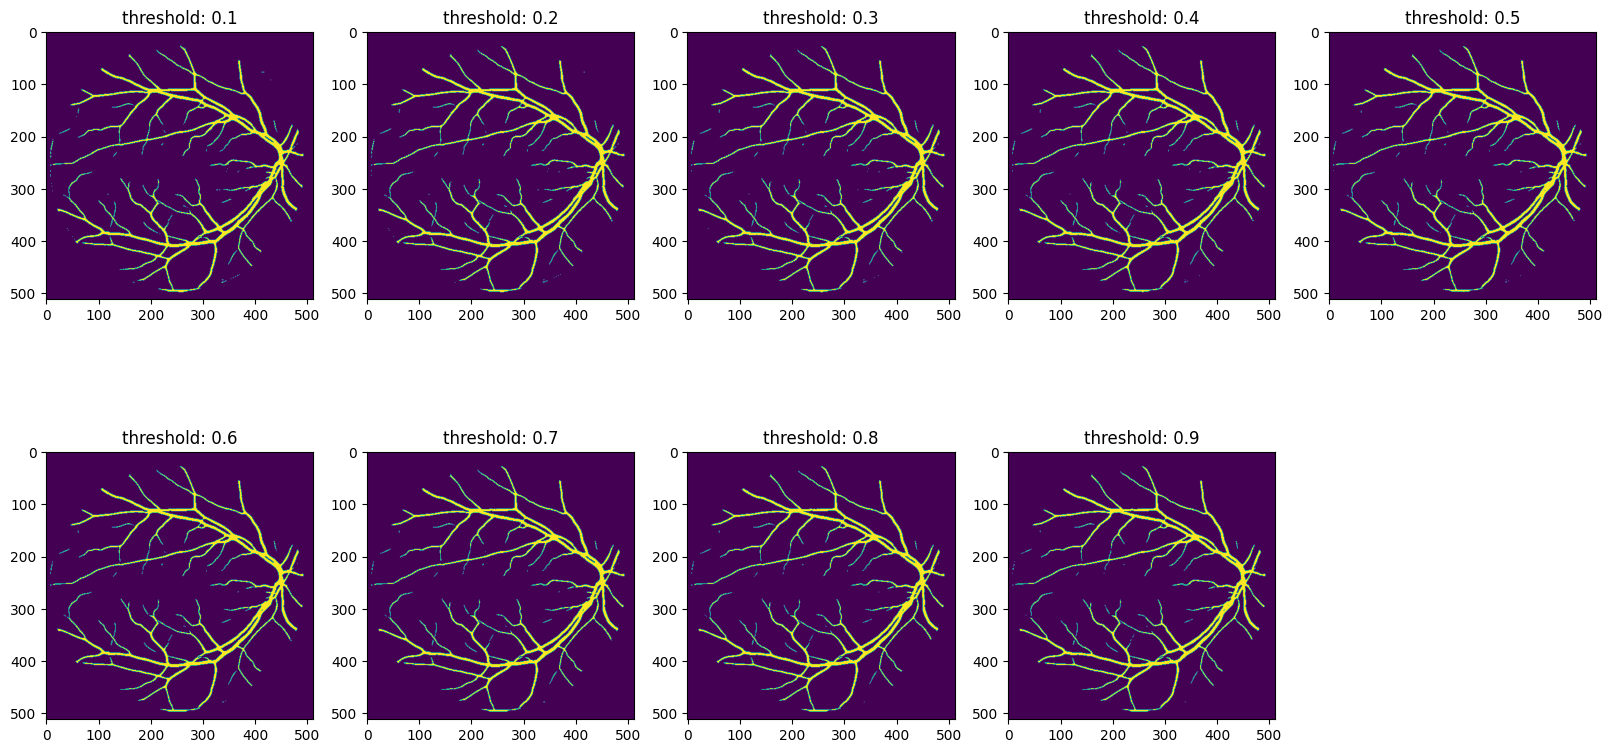

In [17]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

In [11]:
# make prediction
threshold = 0.5
outputs = []
for i in range(len(test_gen)):
    x_test = test_gen[i]
    y_preds = model_final.predict(x_test)
    y_preds[y_preds <= threshold] = 0
    y_preds[y_preds > threshold] = 1
    for y_pred in y_preds:
        dots = np.where(y_pred.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev +1):
                run_lengths.extend((b+1,0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)

1/1 [==============================] - 14s 14s/step


In [12]:
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('submission.csv', index=None)
df

,Id,Predicted
0,0,15082 2 15141 8 15594 2 15652 4 15659 6 16163 ...
1,1,15618 1 16128 5 16147 1 16641 6 16658 3 17154 ...
2,2,13579 5 14090 5 14543 4 14601 5 15054 5 15111 ...
3,3,13047 3 13559 5 14071 5 14584 4 15096 5 15609 ...
4,4,16675 4 17154 2 17187 5 17663 4 17698 5 18174 ...
5,5,18628 4 18728 4 19140 5 19241 4 19653 5 19754 ...
6,6,15631 2 16143 3 16616 2 16655 3 17123 9 17168 ...
7,7,15079 4 15121 6 15591 5 15632 7 16104 5 16144 ...
8,8,14614 4 15090 1 15125 5 15602 2 15636 5 16115 ...
9,9,15102 3 15615 4 16127 4 16598 8 16639 4 17109 ...
